In [2]:
## imports
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

import keras
from keras import backend as K

from keras.layers import Input, Dense, Lambda, Layer, Conv2DTranspose, Reshape, Conv2D, Flatten
from keras.models import Model, Sequential
from keras.datasets import mnist

Using TensorFlow backend.


In [3]:
img_shape = (28, 28, 1)
batch_size = 16
latent_dim = 3 

input_img = keras.Input(shape=img_shape)

encoder = Conv2D(32, 3, padding="same", activation="relu")(input_img)
encoder = Conv2D(64, 3, padding="same", strides=(2,2), activation="relu")(encoder)
encoder = Conv2D(64, 3, padding="same", activation="relu")(encoder)
encoder = Conv2D(64, 3, padding="same", activation="relu")(encoder)


shape_before_flattening = K.int_shape(encoder)

encoder = Flatten()(encoder)
encoder = Dense(32, activation="relu")(encoder)

print(encoder.shape)
z_mean = Dense(latent_dim)(encoder)
z_log_var = Dense(latent_dim)(encoder)

Instructions for updating:
keep_dims is deprecated, use keepdims instead
(?, 32)


In [4]:
def sampling(args):
    z_mean, z_log_var = args
    epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim),
                              mean=0., stddev=1.)
    return z_mean + K.exp(z_log_var) * epsilon

z = Lambda(sampling)([z_mean, z_log_var])

In [5]:
decoder_input = Input(K.int_shape(z)[1:])
decoder  = Dense(np.prod(shape_before_flattening[1:]), activation='relu')(decoder_input)
decoder  = Reshape(shape_before_flattening[1:])(decoder)
decoder  = Conv2DTranspose(32, 3,
                           padding='same', activation='relu',
                           strides=(2, 2))(decoder)
decoder = Conv2D(1, 3, padding='same', activation='sigmoid')(decoder)
decoder = Model(decoder_input, decoder)
z_decoded = decoder(z)

In [ ]:
class CustomVariationalLayer(keras.layers.Layer):

    def vae_loss(self, x, z_decoded):
        x = K.flatten(x)
        z_decoded = K.flatten(z_decoded)
        xent_loss = keras.metrics.binary_crossentropy(x, z_decoded)
        kl_loss = -5e-4 * K.mean(
            1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
        return K.mean(xent_loss + kl_loss)

    def call(self, inputs):
        x = inputs[0]
        z_decoded = inputs[1]
        loss = self.vae_loss(x, z_decoded)
        self.add_loss(loss, inputs=inputs)
        # We don't use this output.
        return x

# We call our custom layer on the input and the decoded output,
# to obtain the final model output.
y = CustomVariationalLayer()([input_img, z_decoded])

In [9]:
from keras.datasets import mnist

vae = Model(input_img, y)
vae.compile(optimizer='rmsprop', loss=None)
vae.summary()

# Train the VAE on MNIST digits
(x_train, _), (x_test, y_test) = mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_train = x_train.reshape(x_train.shape + (1,))
x_test = x_test.astype('float32') / 255.
x_test = x_test.reshape(x_test.shape + (1,))

vae.fit(x=x_train, y=None,
        shuffle=True,
        epochs=10,
        batch_size=batch_size,
        validation_data=(x_test, None))

/Users/ShishirJakati/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: UserWarning: Output "custom_variational_layer_2" missing from loss dictionary. We assume this was done on purpose, and we will not be expecting any data to be passed to "custom_variational_layer_2" during training.
  after removing the cwd from sys.path.


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 28, 28, 1)    0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 28, 28, 32)   320         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 14, 14, 64)   18496       conv2d_1[0][0]                   
__________________________________________________________________________________________________
conv2d_3 (Conv2D)               (None, 14, 14, 64)   36928       conv2d_2[0][0]                   
__________________________________________________________________________________________________
conv2d_4 (

KeyboardInterrupt: 

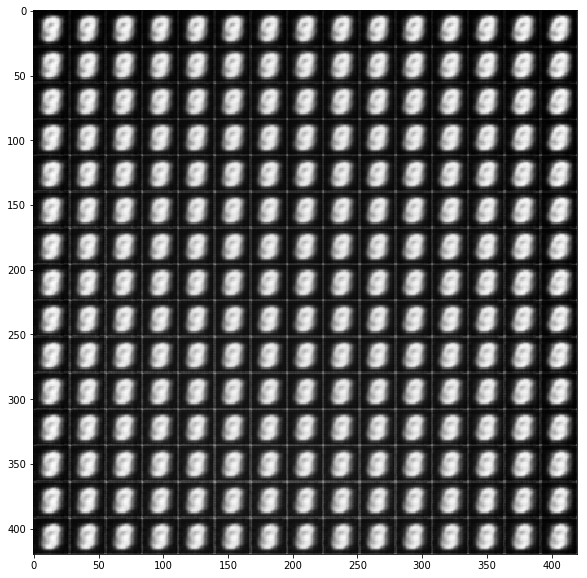

In [11]:
import matplotlib.pyplot as plt
from scipy.stats import norm

# Display a 2D manifold of the digits
n = 15  # figure with 15x15 digits
digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n))
# Linearly spaced coordinates on the unit square were transformed
# through the inverse CDF (ppf) of the Gaussian
# to produce values of the latent variables z,
# since the prior of the latent space is Gaussian
grid_x = norm.ppf(np.linspace(0.05, 0.95, n))
grid_y = norm.ppf(np.linspace(0.05, 0.95, n))

for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        z_sample = np.array([[xi, yi]])
        z_sample = np.tile(z_sample, batch_size).reshape(batch_size, 2)
        x_decoded = decoder.predict(z_sample, batch_size=batch_size)
        digit = x_decoded[0].reshape(digit_size, digit_size)
        figure[i * digit_size: (i + 1) * digit_size,
               j * digit_size: (j + 1) * digit_size] = digit

plt.figure(figsize=(10, 10))
plt.imshow(figure, cmap='Greys_r')
plt.show()

In [12]:
x_test_encoded = vae.predict(x_test, batch_size=batch_size)
plt.figure(figsize=(6, 6))
plt.scatter(x_test_encoded[:, 0], x_test_encoded[:, 1], c=y_test)
plt.colorbar()
plt.show()

ValueError: c of shape (10000,) not acceptable as a color sequence for x with size 280000, y with size 280000